# Linear Regression on Kiloword EEG Dataset

In [75]:
#necessary imports
import os
import mne
from mne.viz import plot_events
from mne.stats import linear_regression
import matplotlib.pyplot as plt

## Loading and Preprocessing

### Load Data, Create Epochs, and Evaluate Metadata

In [13]:
#Load data and create epochs 
path = mne.datasets.kiloword.data_path()
path_raw = os.path.join(path, 'kword_metadata-epo.fif')
epochs = mne.read_epochs(path_raw)

Reading /Users/navyada/mne_data/MNE-kiloword-data/kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
960 matching events found
No baseline correction applied
0 projection items activated


In [159]:
#Get a sense of the metadata for each word that was used
epochs.metadata

,WORD,Concreteness,WordFrequency,OrthographicDistance,NumberOfLetters,BigramFrequency,ConsonantVowelProportion,VisualComplexity
0,film,5.450000,3.189490,1.75,4.0,343.250,0.750,55.783710
1,cent,5.900000,3.700704,1.35,4.0,546.750,0.750,63.141553
2,shot,4.600000,2.858537,1.20,4.0,484.750,0.750,64.600033
3,cold,3.700000,3.454540,1.15,4.0,1095.250,0.750,63.657457
4,main,3.000000,3.539076,1.35,4.0,686.000,0.500,68.945661
...,...,...,...,...,...,...,...,...
955,drudgery,3.473684,1.556303,2.95,8.0,486.125,0.625,69.732357
956,reversal,3.700000,1.991226,2.65,8.0,859.000,0.625,60.545879
957,billiard,5.500000,1.672098,2.90,8.0,528.875,0.625,55.838597
958,adherent,3.450000,0.698970,2.55,8.0,615.625,0.625,68.088112


### Preliminary Data Exploration and Visualization

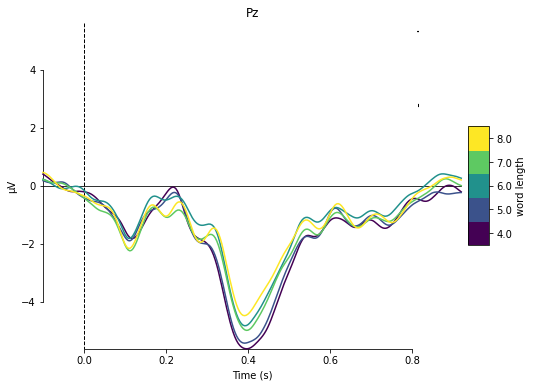

[<Figure size 576x432 with 3 Axes>]

In [15]:
#Let's see how number of letters affects a random EEG channel  
evokeds = dict()
query = 'NumberOfLetters == {}'
for n_letters in epochs.metadata['NumberOfLetters'].unique():
    evokeds[str(n_letters)] = epochs[query.format(n_letters)].average()

mne.viz.plot_compare_evokeds(evokeds, cmap=('word length', 'viridis'),
                             picks='Pz')

In [19]:
#Statistics on the metadata 

epochs_summary = epochs.metadata.describe(include='all').round(3)
print(epochs_summary)

        WORD  Concreteness  WordFrequency  OrthographicDistance  \
count    960       960.000        960.000               960.000   
unique   960           NaN            NaN                   NaN   
top     cool           NaN            NaN                   NaN   
freq       1           NaN            NaN                   NaN   
mean     NaN         4.368          2.438                 2.151   
std      NaN         1.141          0.811                 0.699   
min      NaN         1.650          0.301                 1.000   
25%      NaN         3.450          1.833                 1.700   
50%      NaN         4.350          2.603                 1.950   
75%      NaN         5.350          3.072                 2.600   
max      NaN         6.900          4.070                 8.000   

        NumberOfLetters  BigramFrequency  ConsonantVowelProportion  \
count           960.000          960.000                   960.000   
unique              NaN              NaN               

No projector specified for this dataset. Please consider the method self.add_proj.


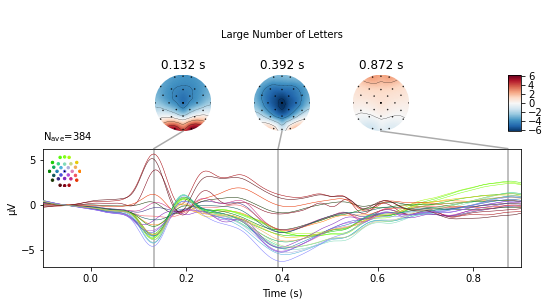

No projector specified for this dataset. Please consider the method self.add_proj.


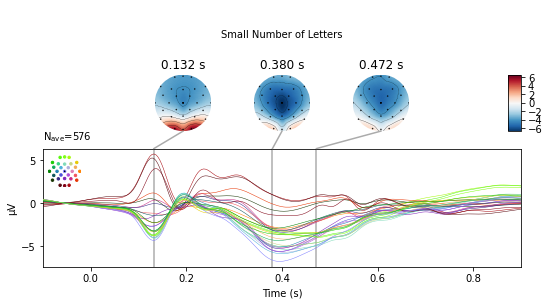

In [160]:
#How does word length (long or short) affect the average ERP across all the EEG channels?

#define the time period to look at (100 ms before and 900 ms after the stimulus)
ts_args = dict(xlim=(-0.1, 0.9))

# plot evoked response for high letter count
epochs['NumberOfLetters > 6'].average().plot_joint( title='Large Number of Letters', ts_args=ts_args);

# and low letter count
epochs['NumberOfLetters <= 6'].average().plot_joint(
                                           title='Small Number of Letters',
                                           ts_args=ts_args);

It doesn't seem like number of letters makes much of a difference here - the butterfly plot and the topograph look very similar in both high and low letter counts. This section was mainly performed to familiarize myself with this type of data and explore functions of MNE.  

## Linear Regression 

In [183]:
#Prepare data 
epochs.interpolate_bads(reset_bads=True);

<ipython-input-183-a95750d6f558>:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True);


In [117]:
# name of predictors
predictor_vars = ['Concreteness',  'WordFrequency',  'OrthographicDistance', 'NumberOfLetters',  'BigramFrequency',  'ConsonantVowelProportion', 'VisualComplexity' ]

# create design matrix
design = epochs.metadata[['Concreteness',  'WordFrequency',  'OrthographicDistance', 'NumberOfLetters',  'BigramFrequency',  'ConsonantVowelProportion', 'VisualComplexity']].copy()
##design['intercept'] = 1


In [118]:
#Create and fit the model 
reg = linear_regression(epochs,
                        design_matrix=design,
                        names=predictor_vars)

Fitting linear model to epochs, (7424 targets, 7 regressors)
Done


In [158]:
print('predictors are:', list(reg))
print('fields are:', [field for field in getattr(reg['Concreteness'], '_fields')])

predictors are: ['Concreteness', 'WordFrequency', 'OrthographicDistance', 'NumberOfLetters', 'BigramFrequency', 'ConsonantVowelProportion', 'VisualComplexity']
fields are: ['beta', 'stderr', 't_val', 'p_val', 'mlog10_p_val']


### Betas and T-Values for Each Predictor (Word Attributes)

No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


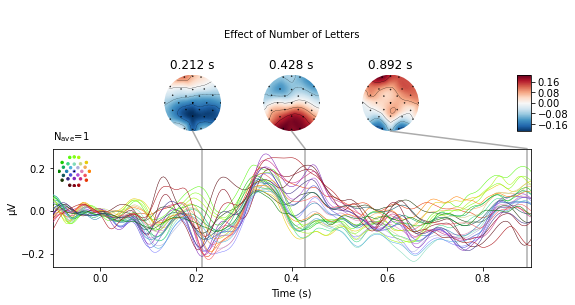

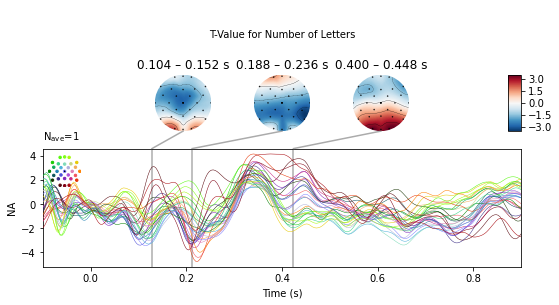

In [176]:
#set timescale and topograph settings 
ts_args = dict(xlim=(-0.1, 0.9))
topomap_args = dict(scalings=dict(eeg=1),
                    average=0.05)
#Plot results of linear regression analysis and corresponding t-values
reg['NumberOfLetters'].beta.plot_joint(ts_args=ts_args,
                                       title='Effect of Number of Letters', show = False);

t_args = dict(xlim=(-0.1, 0.9), unit=False)
reg['NumberOfLetters'].t_val.plot_joint(ts_args=t_args,
                                              topomap_args=topomap_args, title = 'T-Value for Number of Letters');


No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


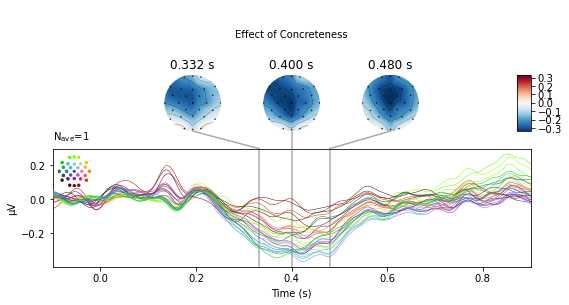

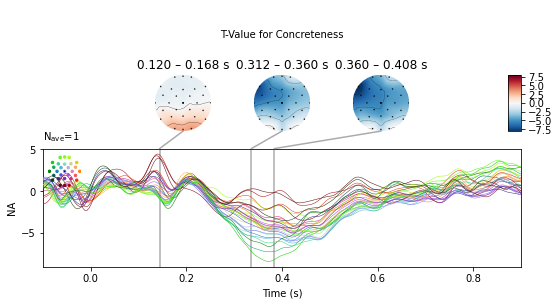

In [177]:
reg['Concreteness'].beta.plot_joint(ts_args=ts_args,
                                       title='Effect of Concreteness',
                                       show = False);
reg['Concreteness'].t_val.plot_joint(ts_args=t_args,
                                              topomap_args=topomap_args, title = 'T-Value for Concreteness');


No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


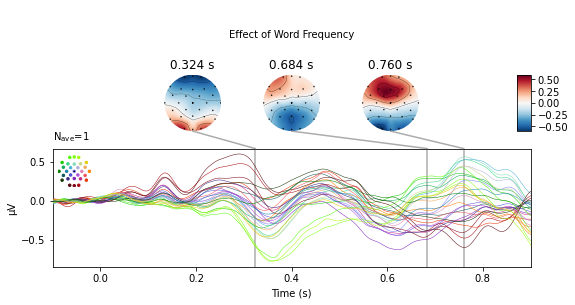

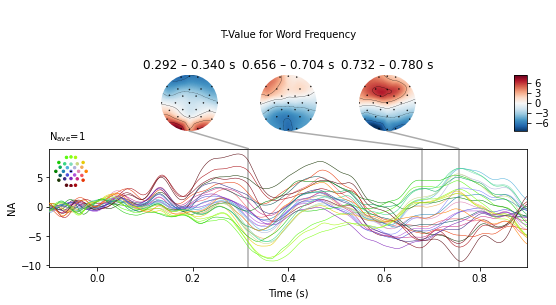

In [178]:
reg['WordFrequency'].beta.plot_joint(ts_args=ts_args,
                                       title='Effect of Word Frequency',
                                       show = False);
reg['WordFrequency'].t_val.plot_joint(ts_args=t_args,
                                              topomap_args=topomap_args, title = 'T-Value for Word Frequency');


No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


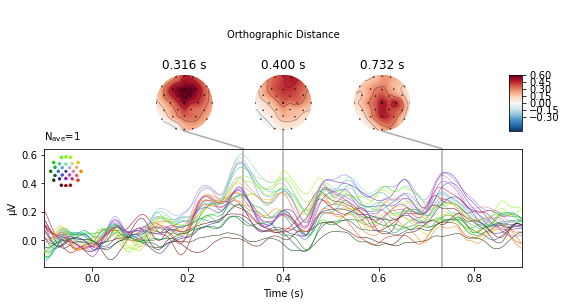

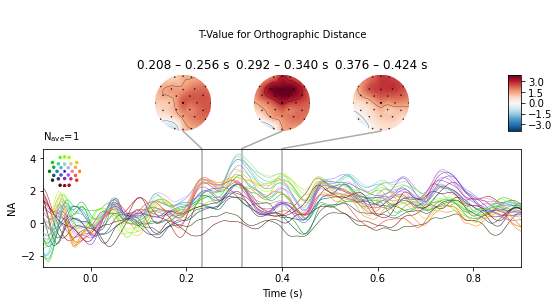

In [179]:
reg['OrthographicDistance'].beta.plot_joint(ts_args=ts_args,
                                       title='Orthographic Distance',
                                       show = False);
reg['OrthographicDistance'].t_val.plot_joint(ts_args=t_args,
                                              topomap_args=topomap_args, title = 'T-Value for Orthographic Distance');


No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


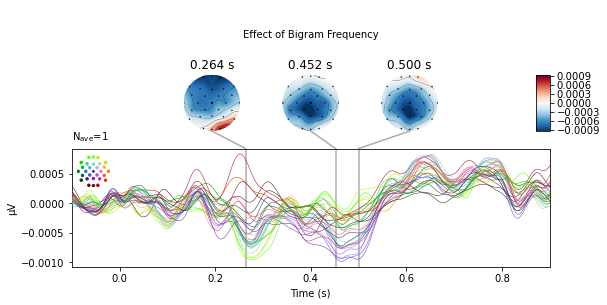

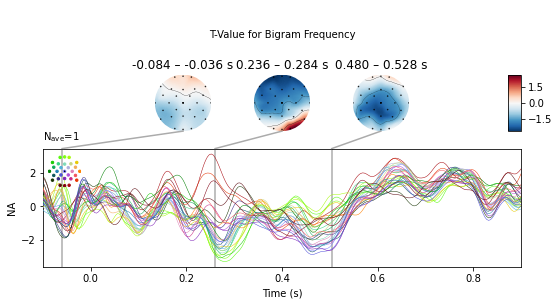

In [180]:
reg['BigramFrequency'].beta.plot_joint(ts_args=ts_args,
                                       title='Effect of Bigram Frequency',
                                       show = False);
reg['BigramFrequency'].t_val.plot_joint(ts_args=t_args,
                                              topomap_args=topomap_args, title = 'T-Value for Bigram Frequency');


No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


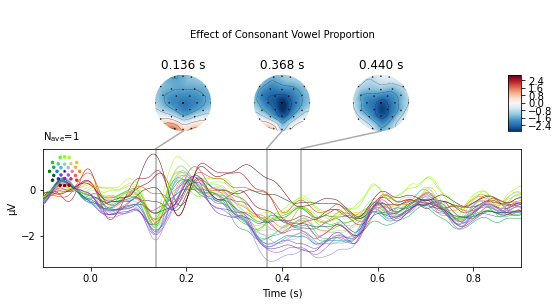

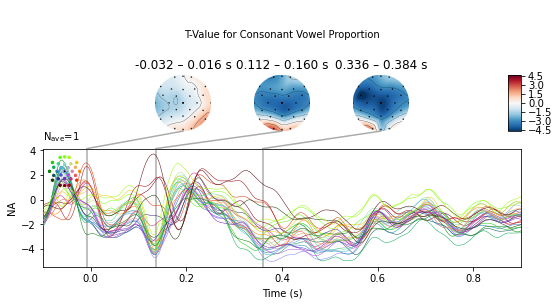

In [181]:
reg['ConsonantVowelProportion'].beta.plot_joint(ts_args=ts_args,
                                       title='Effect of Consonant Vowel Proportion',
                                       show = False);
reg['ConsonantVowelProportion'].t_val.plot_joint(ts_args=t_args,
                                              topomap_args=topomap_args, title = 'T-Value for Consonant Vowel Proportion');


No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


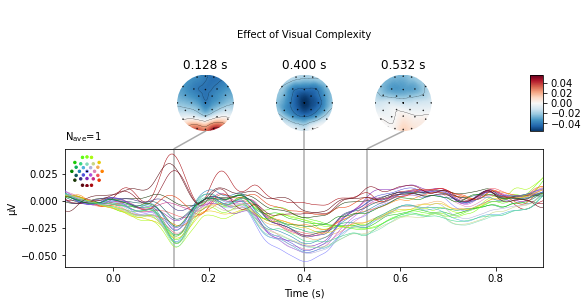

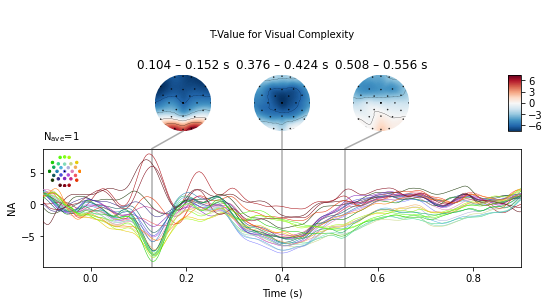

In [182]:
reg['VisualComplexity'].beta.plot_joint(ts_args=ts_args,
                                       title='Effect of Visual Complexity',
                                       show = False);
reg['VisualComplexity'].t_val.plot_joint(ts_args=t_args,
                                              topomap_args=topomap_args, title = 'T-Value for Visual Complexity');
